In [87]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

from sklearn.svm import SVC
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers
import scipy.io
from time import process_time 


## Load and visualize data

In [88]:
mat = scipy.io.loadmat('linear_svm.mat')
X_train = mat["X_train"]
X_test = mat["X_test"]
y_train = mat["labels_train"]
y_test = mat["labels_test"]

## Define SVM problem and solve it with CVXOPT
Soft-margin formulation of the problem

In [89]:
C = 5
X_dash = y_train * X_train
H = np.dot(X_dash , X_dash.T)
N,M = X_train.shape
y_train = y_train.reshape(-1,1) * 1.


P = cvxopt_matrix(H)
q = cvxopt_matrix(-np.ones((N, 1)))
G = cvxopt_matrix(np.vstack((np.eye(N)*-1,np.eye(N))))
h = cvxopt_matrix(np.hstack((np.zeros(N), np.ones(N) * C)))
A = cvxopt_matrix(y_train.reshape(1, -1))
b = cvxopt_matrix(np.zeros(1))

#Run solver
t1 = process_time()
sol = cvxopt_solvers.qp(P, q, G, h, A, b)
t2 = process_time()
lambdas = np.array(sol['x'])

     pcost       dcost       gap    pres   dres
 0: -6.1058e+01 -1.7531e+03  5e+03  8e-01  4e-14
 1: -2.4301e+01 -4.6965e+02  7e+02  8e-02  4e-14
 2: -4.3275e+00 -7.4855e+01  9e+01  9e-03  4e-14
 3: -1.2853e+01 -4.0013e+01  3e+01  3e-03  3e-14
 4: -1.7199e+01 -2.6575e+01  1e+01  6e-04  3e-14
 5: -1.9208e+01 -2.4252e+01  5e+00  2e-04  4e-14
 6: -2.0413e+01 -2.2084e+01  2e+00  6e-15  4e-14
 7: -2.1152e+01 -2.1221e+01  7e-02  5e-16  4e-14
 8: -2.1188e+01 -2.1189e+01  1e-03  3e-15  4e-14
 9: -2.1189e+01 -2.1189e+01  2e-04  4e-16  4e-14
10: -2.1189e+01 -2.1189e+01  2e-06  9e-15  5e-14
Optimal solution found.


In [90]:
# Extract parameters w and b
w = np.matmul((y_train * lambdas).T, X_train).reshape(-1,1)
S = ((lambdas > lambdas.mean()) * (lambdas < C)).flatten()
b = (y_train[S] - np.dot(X_train[S], w))[0]


In [86]:
# Train a linear SVM using sklearn for comparison

clf = SVC(C = 5, kernel = 'linear')
clf.fit(X_train, y_train.ravel()) 

(clf.predict(X_test) == y_test.T).sum() / len(y_test)

0.9788888888888889

## Evaluate model
On test set

In [91]:
print("************ Accuracy *****************")
(np.sign(np.matmul(X_test, w) + b) == y_test).sum() / y_test.shape[0]

************ Accuracy *****************


0.9788888888888889

In [66]:
np.save("w_OtSD", w)
np.save("b_OtSD", b)

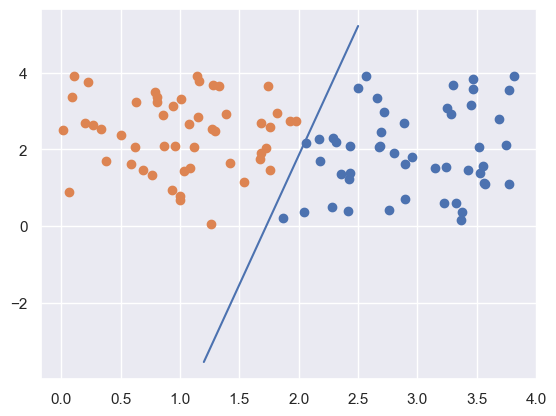

In [19]:
# Plot separation surface
plt.scatter(X_train[y_train.reshape(-1,)==1,0], X_train[y_train.reshape(-1,)==1,1])
plt.scatter(X_train[y_train.reshape(-1,)==-1,0], X_train[y_train.reshape(-1,)==-1,1])
plt.plot(np.linspace(1.2,2.5), np.linspace(1.2,2.5) * (-w[0]/w[1]) - b[0]/w[1])